In [1]:
import baestorm
import GPy
import GPyOpt
import copy
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pystorms import environment
from functools import partial
from GPyOpt.methods import BayesianOptimization

In [2]:
plt.style.use('seaborn-white')
plt.rcParams["figure.figsize"] = (12,8)
plt.rcParams['axes.linewidth'] = 1.0
plt.rcParams['lines.linewidth'] = 2.0
plt.rcParams['font.size'] = 14.0
plt.rcParams['font.sans-serif'] = 'Helvetica'

In [3]:
def gaussian_flows(x, mu=0.0, sigma=1.0):
    y = (1.0/(sigma*(np.sqrt(2.0*np.pi)))) * np.exp(-0.5*((x-mu)/sigma)**2)
    return y
gaussian_flows = np.vectorize(gaussian_flows)

In [4]:
means = [0.0]
sigma = np.linspace(0.5, 1.0, 20)
scale = 5.0

inflows = {}
count = 0
for mu in means:
    for sig in sigma:
        inflows[str(count)] = scale * gaussian_flows(np.linspace(-10.0, 10.0, 100), mu, sig)
        count += 1
inflows = pd.DataFrame.from_dict(inflows)

Text(0, 0.5, 'Flow')

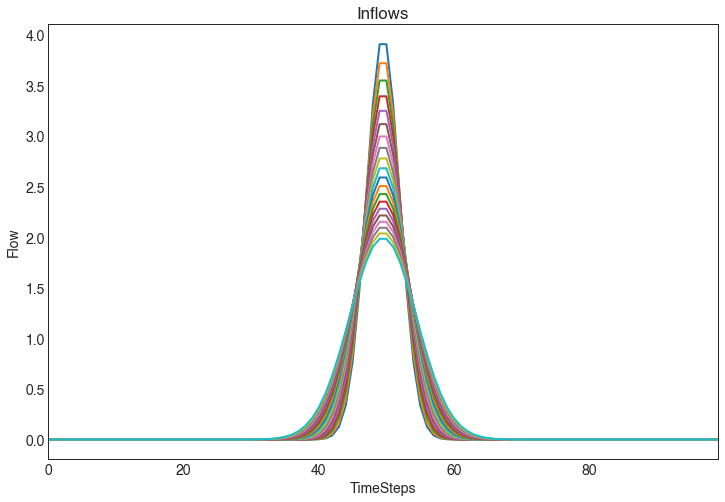

In [5]:
ax = inflows.plot(legend=False, title="Inflows")
ax.set_xlabel("TimeSteps")
ax.set_ylabel("Flow")


In [6]:
def single_basin(actions, flows):
    env = environment(baestorm.load_networks("parallel"), False)
    data = {}
    data["outflow"] = []
    data["overflow"] = []
    data["depth"] = []
    # pad inflows, so that the systems receds
    flows = np.append(flows, np.zeros(300))
    for time in range(0, len(flows)):
        # set the gate_position
        env._setValvePosition("1", actions)
        # set inflow
        env.sim._model.setNodeInflow("P1", 3 * flows[time])
        env.sim._model.setNodeInflow("P2", 0.0)
        # record_data
        data["outflow"].append(env._getLinkFlow("1"))
        data["overflow"].append(env.sim._model.getNodeResult("P1", 4))
        data["depth"].append(env._getNodeDepth("P1"))
        # step through simulation
        _ = env.step()
    env.terminate()
    return data["outflow"], sum(data["overflow"]), data["depth"]

In [9]:
data_flows = {}
for i in inflows.keys():
    flows, overflow, depth  = single_basin(0.4, inflows[i].values)
    data_flows[i] = flows
data_flows = pd.DataFrame.from_dict(data_flows)

Text(0, 0.5, 'Outflow')

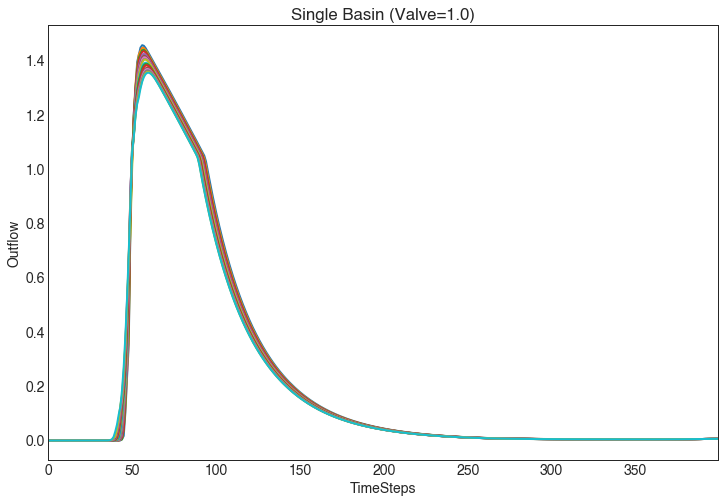

In [10]:
ax = data_flows.plot(legend=False, title="Single Basin (Valve=1.0)")
ax.set_xlabel("TimeSteps")
ax.set_ylabel("Outflow")

In [96]:
def objective_function(x):
    valves = x[0][0]
    # Sample a random inflow
    temp_1 = np.random.choice(np.linspace(0, 19, 20, dtype=int))
    # Simulate and generate flow transformations 
    flows, overflows, depth = single_basin(valves, inflows[str(temp_1)].values)
    # If completely closed, then penalize on depth
    threshold=1.0
    # IF flows exceed threhold, penalize based on the diviation
    flows = pd.Series(flows)
    overflows = pd.Series(overflows)
    
    # Total Inflow 
    sum_inflows = inflows[str(temp_1)].sum()
    sum_overflows = overflows.sum()

    # Flow below threshold
    flows[flows > threshold] = 0.0
    sum_flows_b_thres = flows.sum()
    
    reward = - np.exp(sum_flows_b_thres/(sum_inflows+10**(-5)) + sum_overflows/(sum_inflows+10**(-5)))
    return reward

In [133]:
class ObjectiveFunction:
    def f(self, x):
        return objective_function(x)
f_temp = ObjectiveFunction()
objective = GPyOpt.core.task.SingleObjective(f_temp.f)
search_space = GPyOpt.Design_space(space=[{"name": "var_1", "type": "continuous", "domain": (0.0, 1.0)}])
# Create a sum of kernel
kernel_sum = GPy.kern.RBF(1) + GPy.kern.White(1)
# Create the domain
domain = [{"name": "var_1" , "type": "continuous", "domain": (0.0, 1.0)}]
model = GPyOpt.models.GPModel(kernel=kernel_sum,
                              noise_var=0.0, # how does one pick this? is this updated?
                              optimize_restarts=5,
                              verbose=False)
initial_design = GPyOpt.experiment_design.initial_design('random', search_space, 5)
acq_optimizer = GPyOpt.optimization.AcquisitionOptimizer(search_space)
acquisition = GPyOpt.acquisitions.AcquisitionEI(model, search_space, acq_optimizer)
# --- CHOOSE a collection method
evaluator = GPyOpt.core.evaluators.Sequential(acquisition)
bo = GPyOpt.methods.ModularBayesianOptimization(model,
                                                search_space,
                                                objective,
                                                acquisition,
                                                evaluator, 
                                                initial_design)
max_iter  = 200                                         
bo.run_optimization(path_to_save="./", max_iter = max_iter) 

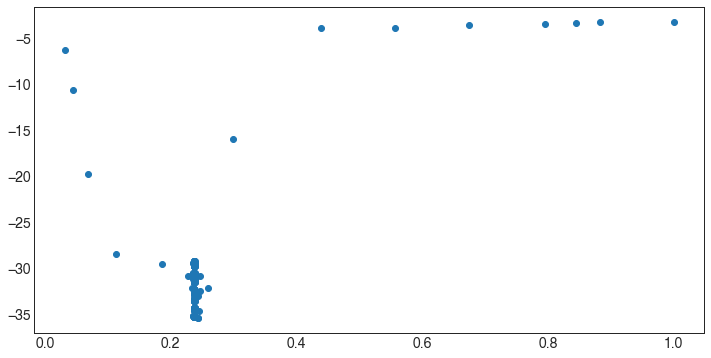

In [134]:
plt.plot(bo.X, bo.Y, 'o')

In [137]:
y_train = np.array(bo.Y)
x_train = np.array(bo.X)

Text(0.5, 1.0, 'Normalized Data')

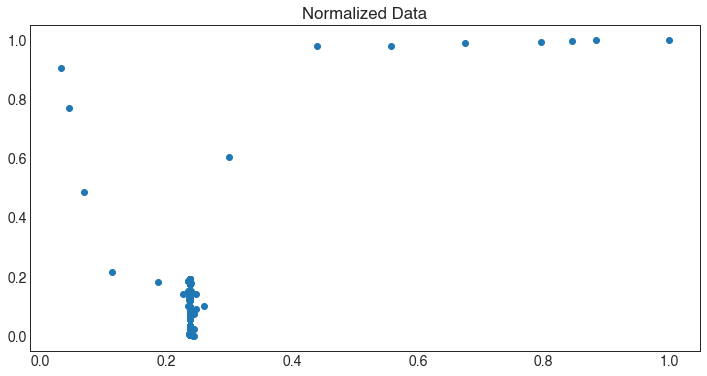

In [138]:
plt.rcParams["figure.figsize"] = (12,6)
y = copy.deepcopy(y_train)
y_train = (y - np.array(y).min())/(np.array(y).max() - np.array(y).min())
plt.plot(x_train, y_train, 'o')
plt.title("Normalized Data")

Text(0.5, 1.0, 'Normalized Data')

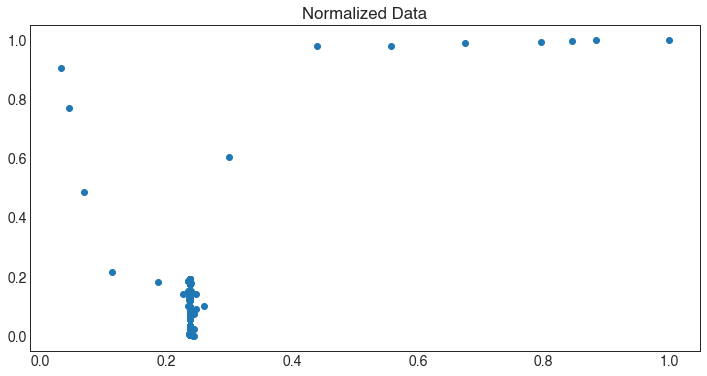

In [139]:
plt.plot(x_train, y_train, 'o')
plt.title("Normalized Data")

In [140]:
kernel_vgp = GPy.kern.RBF(input_dim=1) + GPy.kern.White(input_dim=1)
vgp = GPy.models.GPRegression(x_train.reshape(-1,1), y_train.reshape(-1,1), kernel_vgp)
vgp.optimize(messages=False)
vgp.optimize_restarts(num_restarts = 10)

Optimization restart 1/10, f = -251.98689271085314
Optimization restart 2/10, f = -253.16282795099715
Optimization restart 3/10, f = -251.9868927107094
Optimization restart 4/10, f = -253.16282795096373
Optimization restart 5/10, f = -251.9868927105962
Optimization restart 6/10, f = -251.98689265341716
Optimization restart 7/10, f = -251.98689230685162
Optimization restart 8/10, f = -253.16282794919928
Optimization restart 9/10, f = -251.98689271003775
Optimization restart 10/10, f = -253.16282791580375


Text(0.5, 1.0, 'Objective Function')

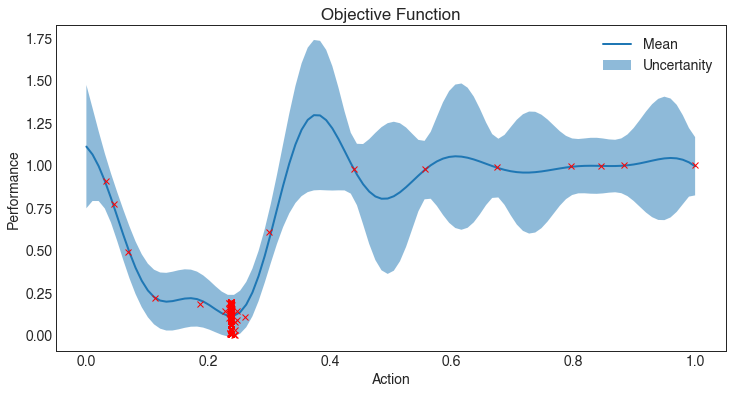

In [141]:
# Plot error bounds
x_test = np.linspace(0.0,1.0, 100)
m, v = vgp.predict(x_test.reshape(-1,1))
up = m.reshape(-1) + 2.0*np.sqrt(v.reshape(-1))
dwn = m.reshape(-1) - 2.0*np.sqrt(v.reshape(-1))

plt.fill_between(x_test, up, dwn, alpha=0.5, label="Uncertanity")
plt.plot(x_test, m, label="Mean")
plt.plot(x_train, y_train,'x',color='red')
plt.legend()
plt.ylabel("Performance")
plt.xlabel("Action")
plt.title("Objective Function")

In [142]:
# RBF and WhiteNoise kernel
kernel1 = GPy.kern.RBF(input_dim=1) + GPy.kern.White(input_dim=1)
gp1 = GPy.models.GPRegression(x_train.reshape(-1,1),y_train.reshape(-1,1),kernel1)
gp1.optimize(messages=False)
gp1.optimize_restarts(num_restarts = 5)

Optimization restart 1/5, f = -251.98689271085314
Optimization restart 2/5, f = -251.9868927069613
Optimization restart 3/5, f = -251.98689269899944
Optimization restart 4/5, f = -251.98689266311374
Optimization restart 5/5, f = -251.98689269216925


In [181]:
m, v = gp3.predict(x_train.reshape(-1,1))
s = 20
variance_noise = np.zeros(len(x_train))
for j in range(0, len(x_train)):
    var = 0.0
    for i in range(0, s):
        var += 0.5 * (y_train[j] - np.random.normal(m[j], v[j]))**2
    variance_noise[j] = var/s
z = np.log(variance_noise)

Text(0.5, 1.0, 'Noise Mean Estimate')

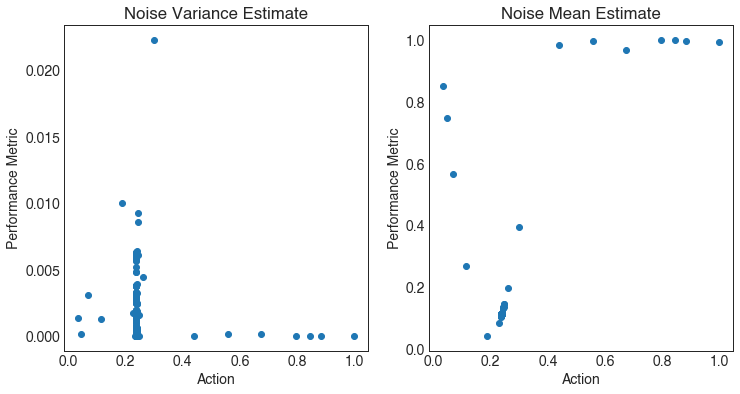

In [182]:
plt.subplot(1,2,1)
plt.plot(x_train, variance_noise,'o')
plt.xlabel("Action")
plt.ylabel("Performance Metric")
plt.title("Noise Variance Estimate")
plt.subplot(1,2,2)
plt.plot(x_train, m,'o')
plt.xlabel("Action")
plt.ylabel("Performance Metric")
plt.title("Noise Mean Estimate")

In [183]:
kernel2 = GPy.kern.RBF(input_dim=1) + GPy.kern.White(input_dim=1)
gp2 = GPy.models.GPRegression(x_train.reshape(-1,1),z.reshape(-1,1),kernel2)
gp2.optimize(messages=False)
gp2.optimize_restarts(num_restarts = 2)
m_n, v_n = gp2.predict(x_train.reshape(-1,1))

Optimization restart 1/2, f = 390.0246743580265
Optimization restart 2/2, f = 390.02467435825474


In [184]:
rbf = GPy.kern.RBF(input_dim=1)
noise = GPy.kern.WhiteHeteroscedastic(input_dim=1, num_data=x_train.shape[0])
k3 = rbf + noise
gp3 = GPy.models.GPRegression(x_train.reshape(-1,1), y_train.reshape(-1,1), k3)
k3.parts[1].variance = np.exp(m_n).reshape(x_train.shape[0])

In [185]:
k3.parts[0] = kernel1.parts[0]
gp3.optimize()
gp3.optimize_restarts(5)

Optimization restart 1/5, f = -405.9060871118882
Optimization restart 2/5, f = -404.37254237317677
Optimization restart 3/5, f = -404.81419937159694
Optimization restart 4/5, f = -423.2364548667032
Optimization restart 5/5, f = -423.23645277151786


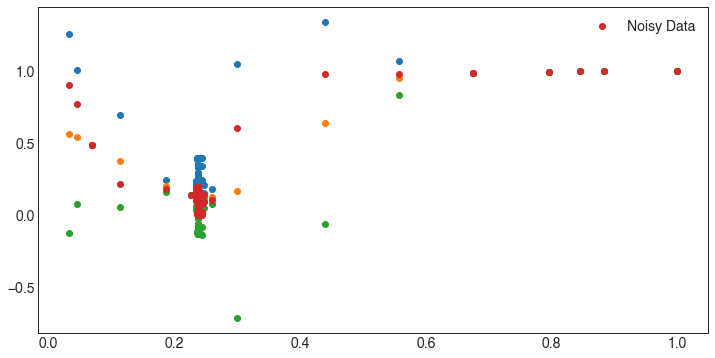

In [186]:
m, v = gp3.predict(x_train.reshape(-1,1))
up = m.reshape(-1) + 2.0*np.sqrt(v.reshape(-1))
dwn = m.reshape(-1) - 2.0*np.sqrt(v.reshape(-1))
plt.plot(x_train, up, 'o')
plt.plot(x_train, m, 'o')
plt.plot(x_train, dwn, 'o')
plt.plot(x_train, y_train, 'o', label="Noisy Data")
plt.legend()

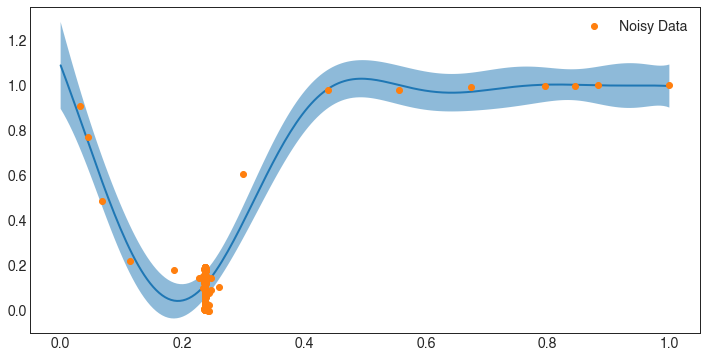

In [187]:
valve = np.linspace(0, 1.0, 205)
m_n, v_n = gp2.predict(valve.reshape(-1,1))
k3.parts[1].variance = np.exp(m_n).reshape(valve.shape[0])
m, v = gp3.predict(valve.reshape(-1,1))
up = m.reshape(-1) + 2.0*np.sqrt(v.reshape(-1))
dwn = m.reshape(-1) - 2.0*np.sqrt(v.reshape(-1))
plt.fill_between(valve, up, dwn, alpha=0.5)
plt.plot(valve, m)
plt.plot(x_train, y_train, 'o', label="Noisy Data")
plt.legend()

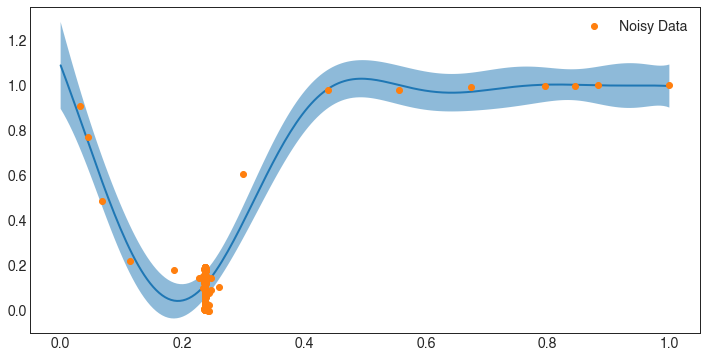

In [188]:
valve = np.linspace(0, 1.0, 205)
m_n, v_n = gp2.predict(valve.reshape(-1,1))
k3.parts[1].variance = np.exp(m_n).reshape(valve.shape[0])
m_t, v_t = gp3.predict(valve.reshape(-1,1))
up_t = m_t.reshape(-1) + 2.0*np.sqrt(v_t.reshape(-1))
dwn_t = m_t.reshape(-1) - 2.0*np.sqrt(v_t.reshape(-1))
plt.fill_between(valve, up_t, dwn_t, alpha=0.5)
plt.plot(valve, m_t)
plt.plot(x_train, y_train, 'o', label="Noisy Data")
plt.legend()

In [159]:
actions = np.linspace(0.0, 1.0, 100)
reward = np.zeros((20, 100))
for action in range(0, 100):
    for rainevent in range(0, 20):
        reward[rainevent, action] = objective_function(actions[action].reshape(-1,1))

In [160]:
reward = (reward - reward.min())/(reward.max() - reward.min())

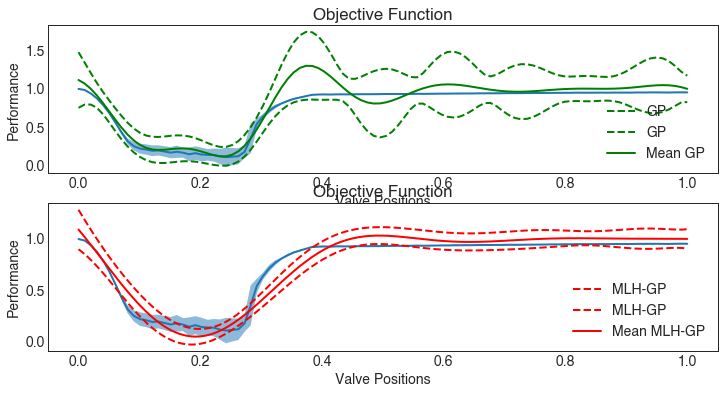

In [189]:
# Reward emperically computed
plt.subplot(2, 1, 1)
m = reward.mean(axis=0)
std = np.std(reward, 0)
up = m + 2.0 * std
dwn = m - 2.0 * std
plt.plot(actions, reward.mean(axis=0))
plt.fill_between(actions, up, dwn, alpha=0.5)
plt.xlabel("Valve Positions")
plt.ylabel("Performance")
plt.title("Objective Function")

x_test = np.linspace(0.0,1.0, 100)
vgp_m, vgp_v = vgp.predict(x_test.reshape(-1,1))
vgp_up = vgp_m.reshape(-1) + 2.0*np.sqrt(vgp_v.reshape(-1))
vgp_dwn = vgp_m.reshape(-1) - 2.0*np.sqrt(vgp_v.reshape(-1))
plt.plot(x_test, vgp_up, '--', color='green', label="GP")
plt.plot(x_test, vgp_dwn, '--', color='green', label="GP")
plt.plot(x_test, vgp_m, '-', color='green', label="Mean GP")

#plt.plot(x_train, y_train,'x',color='red')
plt.legend()

plt.subplot(2, 1, 2)
# VGP Un-estimates
m = reward.mean(axis=0)
std = np.std(reward, 0)
up = m + 2.0 * std
dwn = m - 2.0 * std
plt.plot(actions, reward.mean(axis=0))
plt.fill_between(actions, up, dwn, alpha=0.5)
plt.xlabel("Valve Positions")
plt.ylabel("Performance")
plt.title("Objective Function")


# MLH-GP Un-estimates
plt.plot(valve, up_t, '--', color='red', label="MLH-GP")
plt.plot(valve, dwn_t, '--', color='red', label="MLH-GP")
plt.plot(valve, m_t, '-', color='red', label="Mean MLH-GP")

# Plot error bounds
#plt.plot(x_train, y_train,'x',color='red')
plt.legend()


In [190]:
data_to_save = {
    "emp_x": actions,
    "emp_y_mean": reward.mean(axis=0),
    "emp_y_up":up,
    "emp_y_dwm":dwn,
    "vgp_x":x_test,
    "vgp_y_mean": vgp_m,
    "vgp_y_up":vgp_up,
    "vgp_y_dwm":vgp_dwn,
    "hgp_x":valve,
    "hgp_y_mean": m_t,
    "hgp_y_up":up_t,
    "hgp_y_dwm":dwn_t,
    "sample_x":x_train,
    "sample_y":y_train
}

In [191]:
np.save("./data_ucq1", data_to_save)

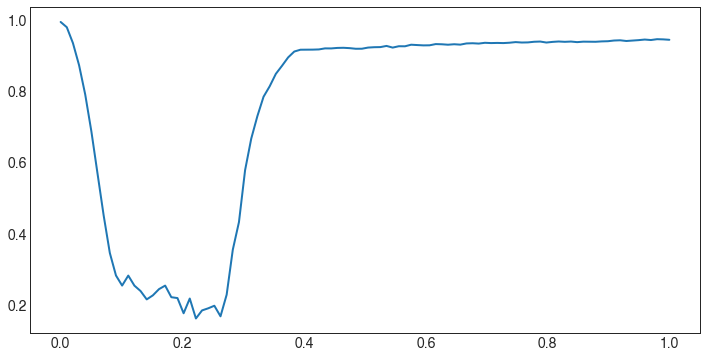

In [271]:
plt.plot(data_to_save["emp_x"], data_to_save["emp_y_mean"])

In [3]:
np.load()

NameError: name 'np' is not defined